In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
import folium
import string
from helpers import *
from IPython.display import HTML

ALPHA = string.ascii_letters
pd.options.mode.chained_assignment = None  # default='warn'

# What's on my plate?

As a reminder, our initial research questions are:

- What is the proportion of imported products per country?
- Which countries contribute most to the environment through eco-friendly packages?
- Which countries have the largest variety of organic-labeled products?
- How healthy do we eat in the different countries?

With those in mind, we will analyze the dataset in order to see which features would be usefull to answer them and and most of all find if there is enough data to answer them!

The goal is to have an extensive analysis of what we eat depending on where we live. Hence, we will be using these four research questions to answer the following:

- What's on my plate?

# Data cleaning

### Loading the CSV file
The CSV File is stored on our computer with the name `OpenFood.csv`. From opening it with a text editor, we found out that the cells are separated by tabulations (i.e. by the `\t` character). Even though the file size is approximately 1.7 GB, we still manage to fit it in a dataframe. We start by opening it:

In [2]:
path = ""
file_name = "OpenFood.csv"
data_path = path+file_name
df = pd.read_csv(data_path, sep = '\t')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### DataFrame Exploration

We first have a look at the dataset

In [3]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With this first look at the DataFrame we can immediately remove the following columns as they are useless for our research purposes:

In [4]:
columns_to_drop = [
    'url',
    'creator',
    'created_t',
    'created_datetime',
    'last_modified_t',
    'last_modified_datetime',
    'generic_name',
    'quantity',
    'emb_codes',
    'emb_codes_tags',
    'purchase_places',
    'stores',
    'traces',
    'traces_tags',
    'serving_size',
    'no_nutriments',
    'image_url',
    'allergens', 
    'image_small_url',
    'manufacturing_places_tags',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    'states',        
    'states_en',
    'states_tags',
    'serving_quantity',
    'traces_en',
    'allergens_en',
    'ingredients_that_may_be_from_palm_oil',
    'ingredients_from_palm_oil'
]

In [5]:
# Drop the colums and put the result in a new data frame called df2
df2 = df.drop(columns_to_drop, axis=1)

It is hard to get an idea of what the values are as there are loads of NaN values... To get a better idea of the values from the dataframe, we show the unique values of each columns:

In [6]:
# We create a new dataframe
df_unique = pd.DataFrame()

# For each column
for col in df2.columns:
    # We take only the unique values of every column
    df_unique = pd.concat([df_unique, pd.Series(df2[col].unique())], ignore_index=True, axis=1, copy=False)
df_unique.columns= df2.columns

In [7]:
df_unique.head()

,code,product_name,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,Cacao,"barquette,plastique","barquette,plastique",CROUS,crous,Tartes à la noix de coco,"en:pies,en:sweet-pies,en:coconut-pies","Pies,Sweet pies,Coconut pies",France,...,68.0,14.0,14.0,3.0,2.0,0.112,0.000016,3.1,0.00211,0.0071
2,0000000000123,Sauce Sweety chili 0%,"bocal,plastique","bocal,plastique","Crous Resto',Crous","crous-resto,crous",Compotes de poire,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",Québec,...,300.0,-4.0,-4.0,14.0,NaN,0.069,NaN,3.9,0.04400,0.0095
3,0000000000178,Mini coco,plastique,plastique,Ferme De La Frémondière,ferme-de-la-fremondiere,Baguettes,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...","Québec,Canada",...,0.0,15.0,15.0,NaN,NaN,0.079,NaN,2.8,0.02600,0.0070
4,0000000000291,Mendiants,"carton,plastique","carton,plastique",Crous,crous-resto,"Pavés de saumon,Saumons fumés,Pavés de saumon ...","en:seafood,en:fishes,en:salmons,en:smoked-fish...","Seafood,Fishes,Salmons,Smoked fishes,Smoked sa...",United Kingdom,...,12.0,29.0,29.0,NaN,NaN,0.066,NaN,4.0,0.02800,0.0110


Since there is a large number of NaN values we also show the number of non NaN values of each column along with the number of different values in each of the columns:

In [8]:
# We initialize the columns to be used in the table that will be shown
cols = ['Number of non NaN values per column', 'Number of different values in each columns']

# We create a table to show the informations
describe_df = pd.DataFrame([df2.count(),df_unique.count()]).transpose()
describe_df.columns = cols
describe_df['ColNumber'] = np.arange(df_unique.shape[1])
describe_df.head(10)

,Number of non NaN values per column,Number of different values in each columns,ColNumber
code,699090,698939,0
product_name,672964,480629,1
packaging,140857,25249,2
packaging_tags,140854,20322,3
brands,464919,99804,4
brands_tags,464886,80928,5
categories,180674,64516,6
categories_tags,180673,37212,7
categories_en,180639,37209,8
origins,42706,7546,9


After further looking into the dataset, we see that there are some columns that are redundant such as `packaging` and `packaging_tags` so we keep only one of the two. For this specific example we only keep the `packaging_tags` column as the values are more consistent. We also remove some other columns. The reasons for the removal are stated as comment in the cell below:

In [9]:
columns_to_drop_2 = [
    'packaging', # The values are redundant and be used in packaging_tags
    'brands', # brands_tags has more stable (same rows are represented in different ways) values
    'categories', # categories_tags has more stable values
    'categories_en', # categories_tags has more stable values
    'origins', # origins_tags has more stable values
    'labels', # labels_tags has more stable values
    'labels_en', # labels_tags has more stable values
    'first_packaging_code_geo', # Not interesting for our research questions
    'cities', # Contains only NaN values and not really intresting for our research questions
    'cities_tags', # Contains only NaN values and not really intresting for our research questions
    'countries', # Seem to contain useless duplicated values (France, en:FR, en:france,...)
    'additives_n', # Not relevant for our research
    'additives_tags', # Not relevant for our research
    'nutrition_grade_uk', # Only NaN values
    'countries_en', # The countries_tags column gives a more stable result
    'ingredients_text', # too hard to deal with and not really intresting after seeing the values
    'additives', # Not needed for our research question, only the number of additives can be interesting
    'additives_en', # Not needed for our research question, only the number of additives can be interesting
    'ingredients_that_may_be_from_palm_oil_n', # As we already keep ingredients_from_palm_oil_n
    'ingredients_that_may_be_from_palm_oil_tags', # As we already keep ingredients_from_palm_oil_n
    'nutrition_grade_fr', # Contains only NaN values
    'ingredients_from_palm_oil_tags', # Not useful for our research
    'ingredients_from_palm_oil_n', # Not useful as well
    'main_category_en' # The main_category column has more stable values
]

Now for the nutrition facts we can delete all the columns that have less than 1000 values (count) because if they do, it means that the columns are too specific (like type of sugar) or there aren't enough values in the dataset in the columns to be interessting. Note this means we have to drop the idea of analyzing the carbon footprint as there aren't enough values to answer our carbon foot print analysis

In [10]:
# Creating the list of all the food fact (ingredients) column to delete since we do not need them for our research
describe_df_aux = describe_df.iloc[36:]

# We set them as a list for the removal
food_facts_to_drop = list(describe_df_aux.index.values)

# We remove the nutrition score from the list since they are needed
food_facts_to_drop.remove('nutrition-score-fr_100g')
food_facts_to_drop.remove('nutrition-score-uk_100g')

Now that we have the two lists we can merge them and then drop the columns:

In [11]:
# Merging the two list created above to remove them
columns_to_drop_merged = columns_to_drop_2 + food_facts_to_drop
# Deleting and storing in a new dataframe
df3 = df2.drop(columns_to_drop_merged, axis = 1)

Now we can wonder if the `code` column can be set as the index:

In [12]:
df3.code.is_unique

False

So the code column is not unique let's see how many values are duplicated:

In [13]:
# We take all the rows where the code is duplicates
duplicate_codes_indices = np.where(df3.duplicated('code', keep=False).values)[0]
dups = df3.iloc[duplicate_codes_indices].copy()
dups.code = dups.code.astype(float)

# We sort so that the duplicated rows are on top of each other
dups.sort_values(by = 'code', inplace = True)

# Show the result
dups.head()

,code,product_name,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places,labels_tags,countries_tags,pnns_groups_1,pnns_groups_2,main_category,nutrition-score-fr_100g,nutrition-score-uk_100g
66475,50.0,Boisson instantanée,NaN,herbalife,NaN,NaN,NaN,NaN,en:france,NaN,NaN,NaN,NaN,NaN
535902,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,NaN,NaN,NaN,NaN,NaN
596588,734.0,NaN,NaN,NaN,"en:groceries,en:condiments,en:sauces,en:soy-sa...",NaN,NaN,NaN,en:vietnam,Fat and sauces,Dressings and sauces,en:groceries,NaN,NaN
167953,734.0,"Enjoy Life Chewy Bars, Soy free, Nut free, Glu...",NaN,NaN,NaN,NaN,NaN,NaN,en:united-states,unknown,unknown,NaN,NaN,NaN
10873,116022.0,British marrowfat processed peas in water - su...,NaN,by-sainsbury-s,NaN,NaN,NaN,NaN,en:united-kingdom,unknown,unknown,NaN,NaN,NaN


As it can be seen there are two types of duplicates:
Some codes (`code` column) appear twice and some codes are NaN. As it can be observed when codes are duplicated, they are often the same product and sometimes one of the rows contains more information than the other for the same code. So we could just keep the rows that contain the most information. And for the rows with NaN as code, the values of the columns are not matching the column names so there must be a shift of values. As a lot of values are missing, it would be complex to recover the true data and there are only 34 rows with code equal to NaN, so we can delete them:

In [14]:
dups = dups[dups != float('nan')]

dups['nb_of_features'] = np.sum(dups.notnull(), axis=1)
dups.reset_index(inplace = True)
indices_to_remove = dups.sort_values(['code','nb_of_features'],ascending = True)\
                        .groupby('code',as_index=False).first()['index'].values
df3.dropna(subset=['code'],inplace=True)
df3.drop(indices_to_remove,inplace = True)

We verify that the `code` column of the dataframe is unique:

In [15]:
df3.code.is_unique

True

So we just have to set this column as the index:

In [16]:
df3.set_index('code', inplace = True)

The dataframe has the following shape:

In [17]:
print('{0}(row) x {1}(columns)'.format(df3.shape[0], df3.shape[1]))

698939(row) x 13(columns)


So we are using these proportions of the initial dataframe:

In [18]:
print('{0:1.2f}% of the rows of the initial dataframe'.format(df3.shape[0]/df.shape[0]*100))
print('{0:1.2f}% of the columns of the initial dataframe'.format(df3.shape[1]/df.shape[1]*100))

99.97% of the rows of the initial dataframe
7.51% of the columns of the initial dataframe


### Types and statistics of the features

Let's first check what are the type of the columns of the dataframe:

In [19]:
df3.dtypes

product_name                object
packaging_tags              object
brands_tags                 object
categories_tags             object
origins_tags                object
manufacturing_places        object
labels_tags                 object
countries_tags              object
pnns_groups_1               object
pnns_groups_2               object
main_category               object
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
dtype: object

Here the types are object as there are a lot of NaN values (which are float type) in the text so the python compiler can put string as type. We will be able to replace some of the NaN values later.

Let's plot the percentage of the non NaN values in each general information features i.e. column 0 to 18. The data set is split with respect to some groups of columns to have make a better representation of each category of feature:

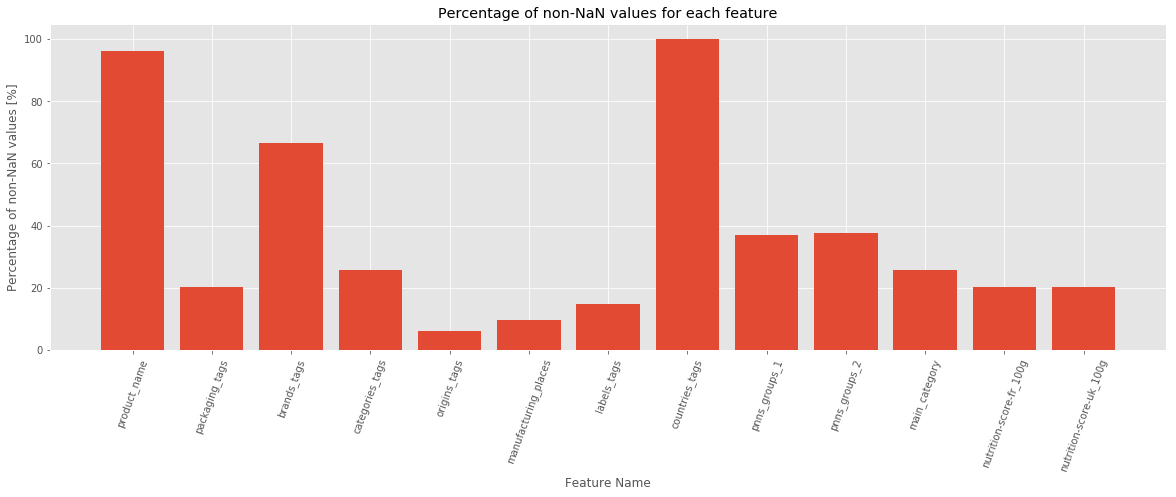

In [20]:
general_info = df3.iloc[:,:18]
plt.figure(figsize=(20,6))
plt.bar(range(general_info.shape[1]),general_info.count()/general_info.shape[0]*100)
plt.xticks(range(general_info.shape[1]), general_info.columns,rotation=70)
plt.title("Percentage of non-NaN values for each feature")
plt.xlabel("Feature Name")
plt.ylabel("Percentage of non-NaN values [%]")
plt.show()

As expected from looking at the data frame, there is a large number of NaN values. Indeed, for the `origin_tags` there is more than 95% of the values that are NaN values. This is compromising a lot with our research question about import. On the other hand, from the `df_unique` dataframe we see that there is still ~50'000 rows that contain an origin tags so we will still be able to do some research (though not as extended as we wished) on a subset of rows.

We also plot an histogram of the count of non-NaN values for each row:

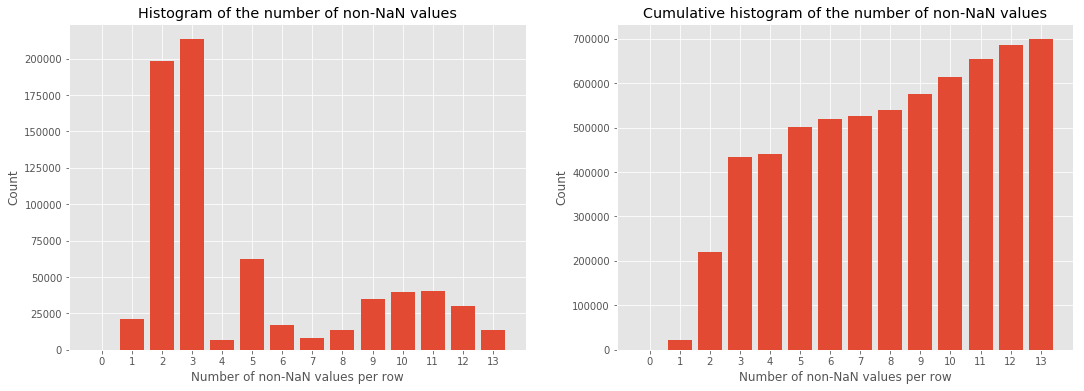

In [21]:
# Plotting 
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(general_info.transpose().count(),
         bins = np.arange(general_info.shape[1]+2)-0.5,
         rwidth = 0.8)
plt.xticks(range(general_info.shape[1]+1))
plt.title("Histogram of the number of non-NaN values")
plt.xlabel("Number of non-NaN values per row")
plt.ylabel("Count")

plt.subplot(122)
plt.hist(general_info.transpose().count(),
         bins = np.arange(general_info.shape[1]+2)-0.5, 
         cumulative=True,
         rwidth = 0.8)
plt.xticks(range(general_info.shape[1]+1))
plt.title("Cumulative histogram of the number of non-NaN values")
plt.xlabel("Number of non-NaN values per row")
plt.ylabel("Count")
plt.show()

By seeing the problem row-wise, we can evaluate the amount of data that we will be able to use. We can see the distribution on the left to get a general idea of the number of non-NaN values for each row. But the most interesting plot is the cumulative on the right. We can see that approximately 500'000 rows have between 0 and 6 non-NaN values. We also notice that only 150,000 rows have between 7 and 13 columns (thus more than half the data). 

### Importing a second data set with all the countries locations

In [22]:
# CSV found on this page: https://developers.google.com/public-data/docs/canonical/countries_csv
countries_df = pd.read_csv("countries.csv", sep = '\t')

# Remove the space at the end of the column names
countries_df.columns = ['country', 'latitude', 'longitude', 'name']

# Setting country as Index
countries_df.set_index('country', inplace = True)
countries_df.head(10)

,latitude,longitude,name
country,,,
AD,42.546245,1.601554,Andorra
AE,23.424076,53.847818,United Arab Emirates
AF,33.939110,67.709953,Afghanistan
AG,17.060816,-61.796428,Antigua and Barbuda
AI,18.220554,-63.068615,Anguilla
AL,41.153332,20.168331,Albania
AM,40.069099,45.038189,Armenia
AN,12.226079,-69.060087,Netherlands Antilles
AO,-11.202692,17.873887,Angola


With this second data set we will be able to see how the products travel across the world. To be more specific, we wil be able to compute the distance traveled from the countries coordinates on the map (by computing the grand circle distance). As we all know, the fact of importing food that comes from far away is bad for the environment. Mainly for vegetable as they have to travel most of the time by plane otherwise they get quickly out of date.

# More analysis of the research questions

### What is the proportion of imported products per country?

With both `origins_tags` and `countries_tags`, we can extract the countries that import the most number of products. We can assume that the name of the product are unique and therefore can be used to look for the number of products sold in or are being sold by a particular country. The countries and origins tags are not cleaned yet, but it is definitely possible to search whether it might countain the name of a known country or the abbreviation of it to do or from one of its cities. We also plan to extract the known coordinate for every country and map them to the origins_tags and countries_tags and display the flow of products inward or outward from every single country and its volume on a world map to know what country produces the most of the products used worldwide or the one that imports the most of its products. With the second data frame we imported, we will be able to show the distance traveled by the product (using the great distant circle) in the world.

In [23]:
# The number of unique values for origins_tags
len(df3["origins_tags"].unique())

6682

In [24]:
# The number of unique values for countries
len(df3["countries_tags"].unique())

1238

In [25]:
# Number of products sold in a specific country
df3.copy().groupby(by = ['countries_tags'])["product_name"].count().head()

countries_tags
ch:schweiz                              2
ch:suisse                              76
de:allemagne                           17
de:frankrike,de:sverige,de:tyskland     1
en:afghanistan                          2
Name: product_name, dtype: int64

In [26]:
# Number of products made in a specific country
df3.copy().groupby(by = ['origins_tags'])["product_name"].count().head()

origins_tags
03-2018                1
08430-jandun,france    1
0se361-3,sweden        1
1-france,3-ue          1
1-mai,alger,algerie    1
Name: product_name, dtype: int64

We notice that the aggregation by `countries_tags` has 1358 possible unique values (excluding NaN) which is much more than the possible number of countries in the world. After exploring the countries_tags, we observe the some products are sold in more than a single country, and the combination of all the product in which it is sold is considered a single entry for `origins_tags`. Thus, a separation of the `countries_tags` is neccessary and reaggregation of the all the products.

We also notice that origins_tags has 6577 unique values (excluding NaN) whici is more than the possible number of countries in the world. After exploring origins_tags, we observe the some origin_tags are more specific about the origins than just including the country. We should clean this column by looking at whether it contains a known name of a country.

### Which countries contribute most to the environment through eco-friendly packages?

Initially, this question was supposed to be centered on packaging and carbon-footprint. However, we noticed that the `carbon-footprint_100g` column has very few non-NaN values:

In [27]:
# We get the number of non-nan values in the carbon-footprint column.
# Here we take the original dataframe to show the result since other dataframes had already deleted this column
df['carbon-footprint_100g'].count()

344

This jeopardizes this research question on one hand since CO2 footprint is a vital aspect and the data is lacking. As a result, we will not be using the CO2 footprint in this research question since we have decided to remove the column. On the other hand, we will be able to move forward by analyzing the `packaging_tags` column. <br>
Let's see if the `packaging_tags` and `countries_tags` column have enough data for this question:

In [28]:
df3['packaging_tags'].count()

140833

In [29]:
df3['countries_tags'].count()

698344

We notice that the data relative to the packaging has more than 130,000 non-NaN values and the data relative to the country where is it ***sold*** is present in nearly all products. In this sense, by using the information of the packaging along with the column `countries_tags`, we can estimate the countries that sell the highest variety of eco-friendly products but only in terms of packaging. 

### Which countries have the largest variety of organic-labeled products? 

This research question appeals to three different columns: `countries_tags`, `categories_tags` and `labels_tags`. The labels and categories have data about wether the products are organic or not, while the countries will be used to identify which of the countries have the largest variety of organic-labeled products.

In [30]:
df3['categories_tags'].count()

180616

We see that we have data of the categories for more than 170,000 products. As a result, this column has enough data to be considered for this research question.

In [31]:
df3['labels_tags'].count()

102260

We also notice that we have data of the labels for more than 100,000 products. As a result, this column has enough data to be considered for this research question. <br>
Since we know that the `countries_tags` column is filled for almost every product, we can conclude that this research question can be answered by looking at the organic labels in `labels_tags` and possibly `categories_tags` and mapping the labels to the countries from `countries_tags`.

### How healthy do we eat in the different countries?

In order to answer this question, we will focus on simply analyzing the nutrition score of every country. The following link provides an overview on how the British nutrition score is computed: https://www.ndph.ox.ac.uk/cpnp/files/about/uk-ofcom-nutrient-profile-model.pdf (also provided and explained in the data story). The nutrition score is computed in such a way that the higher score is, the ***less*** healthy the product is. Let us analyze the nutrition scores of this data set.

In [32]:
df3['nutrition-score-uk_100g'].count()

141668

The British nutrition score is available for more than 130,000 products, which good news for our research. Let's see also information about the French nutrition score (which is computed in a very similar way as the British one.

In [33]:
df3['nutrition-score-fr_100g'].count()

141668

It seems that both are computed for exactly the same number of products. We can also analyze how similar they are.

                         nutrition-score-uk_100g  nutrition-score-fr_100g
nutrition-score-uk_100g                  1.00000                  0.93105
nutrition-score-fr_100g                  0.93105                  1.00000


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


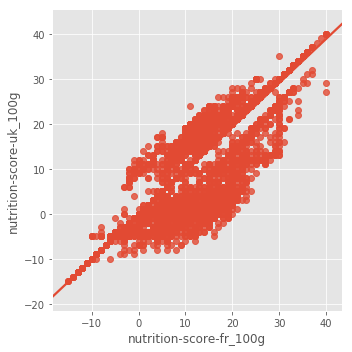

In [34]:
# We first get the data only for the nutrition score
nutritions = df3[['nutrition-score-uk_100g', 'nutrition-score-fr_100g']]

# We print the correlation
print(nutritions.corr())

# We plot to show the correlation
plot = sns.lmplot(y='nutrition-score-uk_100g', x='nutrition-score-fr_100g', data=nutritions, fit_reg=True)
fig = plot.fig 

As a result, we will only focus on one of the nutrition score. We chose to focus on the British, but the French is also a very suitable choice.

### What's on my plate?

Our goal and final question is answering the following question: ***What's on my plate***?
This question uses the different answers we will be providing in the other research questions. After investigating these characteristics, we will show (probabilistic) information depending on the country we live in. The information is split into four categories: 

- Where does the product I eat most likely come from?
- How healthy am I eating?
- How likely am I eating organic products?
- How am I contributing to the environment?

## Answering the research questions 

We first change the name of our dataframe for better readability. 

In [35]:
# Creating a copy in order not to alter the original one
current_data = df3.copy()

### What is the proportion of imported products per country?

In the first part, we only clean the `origins_tags` and the `countries_tags` as they are really dirty:

In [36]:
# All the functions used in this cell are stored in the helpers.py file at root level of the git repository
# They were placed here as the number of lines sum up to 250 line of code

# Further cleaning of the countries tags
ct = clean_coutries_tags(current_data)
current_data['countries_tags'] = ct

# Cleaning of the origins tags
ot = clean_origins_tags(current_data)

# The the values that are in lower case are almost all the time errors
ot[ot.str.islower()] = "Unknown"

# Some of the values contains numbers so we cannot do anyting with them
ot[ot.str.contains('0|1|2|3|4|5|6|7|8|9')] = "Unknown"
current_data['origins_tags'] = ot

# Deleting the unknowns as we cannot assign them to any country 
# and they shouldn't change the distribution of import percentage
current_data = current_data[current_data['origins_tags'] != "Unknown"]

Then we plot the count of product of each top `origins_tags`:

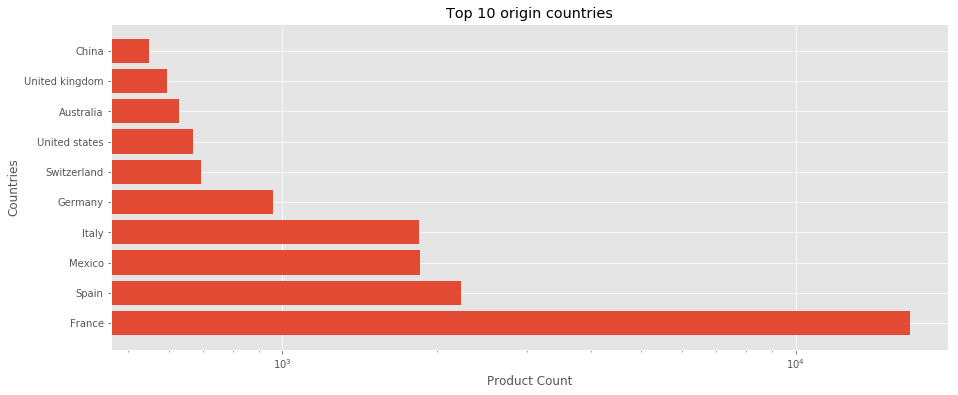

In [37]:
ori_tags = current_data[['origins_tags','product_name']].groupby('origins_tags').count().sort_values(by= 'product_name', ascending=False)

# Dropping european union
ori_tags.drop(ori_tags.index[[1]], inplace=True)

# Plotting the data
plt.figure(figsize=(15,6))
plt.xlabel('Product Count')
plt.ylabel('Countries')
plt.title('Top 10 origin countries')
plt.barh(ori_tags.head(10).index, ori_tags.head(10).product_name, log=True)
plt.show()

We also plot the distribution of the count of product of each top `countries_tags`:

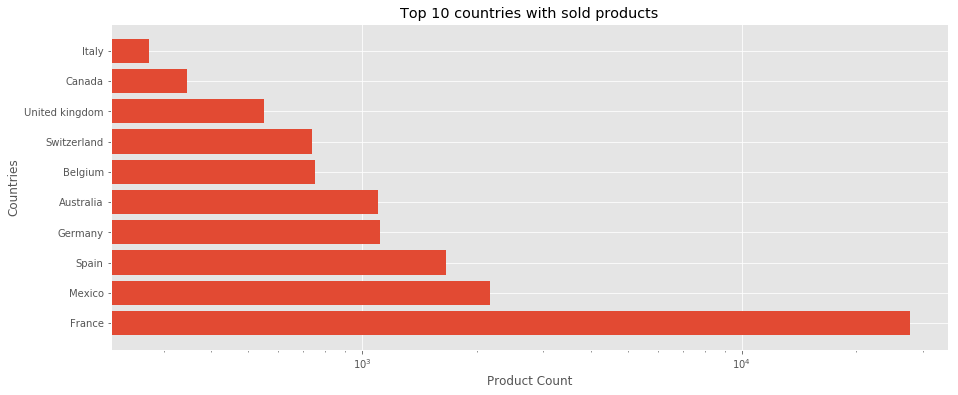

In [38]:
ctry_tags = current_data[['countries_tags','product_name']].groupby('countries_tags').count().sort_values(by= 'product_name', ascending=False)

# Plotting the values
plt.figure(figsize=(15,6))
plt.xlabel('Product Count')
plt.ylabel('Countries')
plt.title('Top 10 countries with sold products')
plt.barh(ctry_tags.head(10).index, ctry_tags.head(10).product_name, log=True)
plt.show()

Now we need to prepare a dataframe that we can use to make some import analysis:

In [39]:
# Removing 'nan' and 'European union'
imp_exp = current_data[current_data['origins_tags'] != 'nan']
imp_exp = imp_exp[imp_exp['origins_tags'] != 'European union']

# Creating a dataframe which a two level index, to store the country in question ine the first level and
# the country from which the food is imported as second index
# And finally, the count of values entry of the index
imp_exp = imp_exp[['countries_tags','origins_tags','product_name']].groupby(['countries_tags','origins_tags'])\
            .count()\
            .sort_values(by='product_name', ascending=False)

# Printing example
imp_exp.head()

product_name
countries_tags origins_tags              
France         France               16317
Mexico         Mexico                1721
France         Italy                 1224
               Spain                 1046
Spain          Spain                  940

Here we define some method we are gonna use to plot show the import percentage for the top countries:

In [40]:
def get_import_export(country, max_ctry = 8):
    """
    Return a tuple containing:
        1) The percentage of products produced in the country and abroad
        2) The percentage of the imported production from the top 15 countries
    """
    # Reseting the index of be able to work with 'origins_tags'
    ctry_ori = imp_exp.loc[country].reset_index()
    
    #Rename the 'product_name' column
    ctry_ori.rename(columns = {'product_name':'percentage'}, inplace = True)
    
    # Transforming the count to percent
    n_prod = ctry_ori['percentage'].sum()
    ctry_ori['percentage'] = ctry_ori['percentage']/float(n_prod)*100
    
    # If there are more than 15 countris, set the one with the lowest percentage 
    # to 'Others' in oder to avoid having to many countries 
    if ctry_ori.shape[0] >= max_ctry:
        ori_t = ctry_ori['origins_tags']
        ori_t[ctry_ori.index > max_ctry] = "Others"
        ctry_ori['origins_tags'] = ori_t
        ctry_ori = ctry_ori.groupby('origins_tags').sum().reset_index()
    
    # Computes the import percentage
    ori_t = ctry_ori['origins_tags'].copy()
    ori_t[ori_t != country] = 'Abroad'
    
    imp_perc = ctry_ori.copy()
    imp_perc['origins_tags'] = ori_t
    imp_perc = imp_perc.groupby('origins_tags').sum()
    
    # Return the tuple
    return (imp_perc,ctry_ori.set_index('origins_tags').sort_values(by='percentage', ascending=False))

In [41]:
def print_import_dist(country):
    """
    Prints the distribution of the 8 best import countries for a specific country given as an argument
    """
    (imp_perc, ctry_ori) = get_import_export(country)
    plt.figure(figsize=(8,4))
    plt.xlabel('Percentage %')
    plt.ylabel('Countries')
    plt.yticks(range(ctry_ori.shape[0]), ctry_ori.index.values)
    plt.title('Distribution of where the food comes from in ' +country )
    plt.barh(range(ctry_ori.shape[0]), ctry_ori.percentage.values)
    plt.savefig('import_dist/'+country.lower()+'_imp_dist.png', bbox_inches = 'tight')
    plt.show()

### Plotting the import distribution for the top best countries

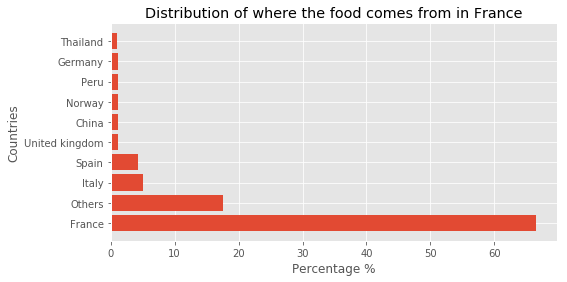

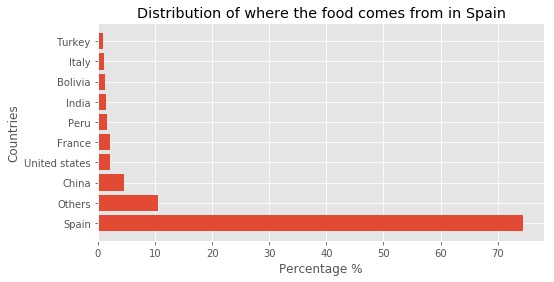

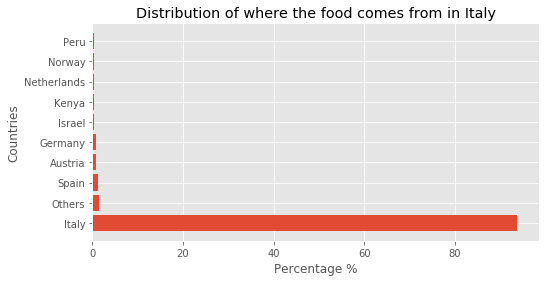

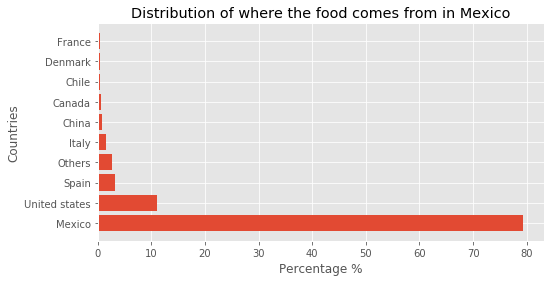

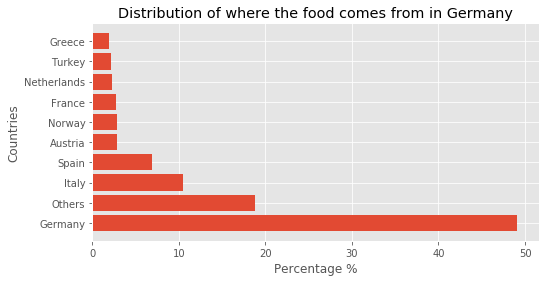

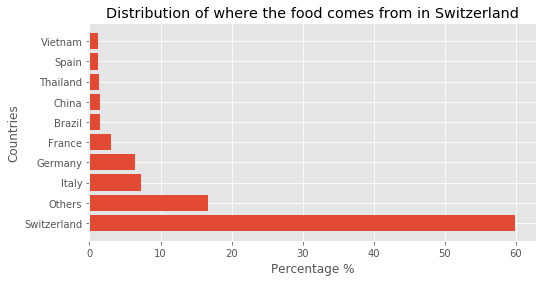

In [42]:
print_import_dist('France')
print_import_dist('Spain')
print_import_dist('Italy')
print_import_dist('Mexico')
print_import_dist('Germany')
print_import_dist('Switzerland')

### Plotting the map to represent the import

First we prepare the cooridnate dataset:

In [43]:
# Perparing the coordinates data_frame
coordinates = countries_df.copy()
ctry_name = coordinates.name.astype(str)
ctry_name = ctry_name.str.capitalize()
coordinates.name = ctry_name
coordinates.reset_index(inplace = True)
coordinates.set_index('name', inplace = True)

In [44]:
def add_import_line(world, country, n_lines = 10):
    """
    Adds import lines for a specific country on the map passed as argument
    """
    # Coordinates of the country in question
    country_coord = tuple(coordinates.loc[country,['latitude','longitude']])
    
    # Getting import data
    (_, top_import) = get_import_export(country, max_ctry = n_lines)
    
    # Dropping the country in question and the 'Other label' from the 
    # dataframe in order to only have the top import countries
    top_import = top_import.drop(country)
    if top_import.index.isin(['Others']).sum() != 0:
        top_import = top_import.drop('Others')
    
    # Prints a line on the map from the county in question to the
    # the 'n_lines' best import countries
    for ctry in top_import.index:
       
        #Some countries mihght not be in the index so we skip them
        if ctry not in coordinates.index:
            continue
        coord = tuple(coordinates.loc[ctry,['latitude','longitude']])
        coords = [country_coord, coord]
        
        # Adds the line to the map
        world.add_child(folium.PolyLine(locations=coords, weight=1))

We create the map of the world and add lines to link countriy that have import relations:

In [45]:
# Creating a folium map
world = folium.Map(location=[30, 10], zoom_start=2)

# Adding a link to every top import country for the top 12 origin tags
for country in ori_tags.head(12).index:
    add_import_line(world, country, n_lines = 15)

# Saving the map
world.save('import_map.html')

# Printing the map
HTML('<iframe src="import_map.html" height=500 width=900></iframe>')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Which countries contribute most to the environment through eco-friendly packages?

In order to answer this question, it is important to do some research to understand which packaging are the most/least eco-friendly. Online websites such as https://bizfluent.com/facts-6743400-eco-friendly-packaging-.html gave us some insights. First, we noticed that the 
Our research research has led to following conclusions:

In [46]:
# We first take the rows with a non-null value in packaging_tags
packaging_list_not_null = current_data[current_data['packaging_tags'].notnull()]

# We then take only the columns we are interested in: packaging_tags and countries_tags
packaging_list = packaging_list_not_null[['countries_tags','packaging_tags']]

# We put packaging_tags in a list, separate them by the "," which separates the different packaging
packaging_list['packaging_tags'] = packaging_list['packaging_tags'].str.split(',')

# We set the countries_tags as index to "explode" the list into different rows
packaging_list = packaging_list.set_index('countries_tags')
 
# We do the "explode"
packaging_list = (packaging_list.packaging_tags.apply(pd.Series)
              .stack()
              .reset_index(level=1, drop=True)
              .to_frame('packaging'))

# We reset the index
packaging_list = packaging_list.reset_index(level=0)

packaging_list = packaging_list.reset_index(level=0)

# Show the output
packaging_list.head(10)

,index,countries_tags,packaging
0,0,France,carton
1,1,France,plastique
2,2,Canada,frais
3,3,Canada,frais
4,4,United kingdom,paper
5,5,United kingdom,plastic-film
6,6,Canada,frais
7,7,Canada,frais
8,8,Canada,plastique
9,9,Canada,frai


Now that we have for each country what packaging it uses for each product, we need some way to quantify it. Thus, we create a dictionary containing for each packaging a certain grade, where the higher the grade the more it is eco-friendly. We can then group by the country and take the mean (dividing by the number of products).

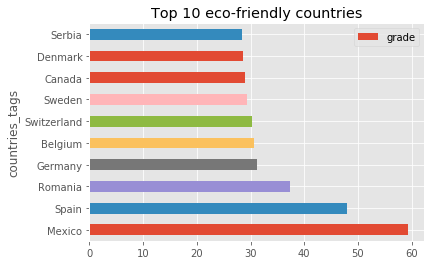

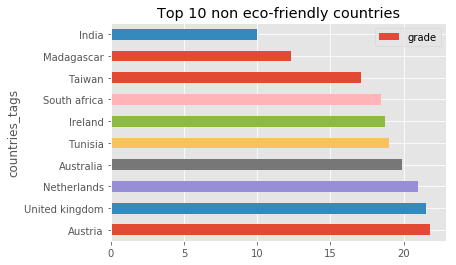

In [47]:
# Setting up the grades for each packaging type
# Note that we take the most common packaging types, where some appear in both french and english
# The highest the score, the more the packaging is eco-friendly
packaging_to_grade = {
    'carton': 60,
    'cardboard': 60,
    'paper': 50,
    'papier':50,
    'verre':40,
    'glass':40,
    'metal':30,
    'canette':30, #canette is considered as metal
    'aluminium':20,
    'plastique': 10,
    'plastic': 10,
    'sachet-plastique': 10,
    'plastic-bag': 10
}

# We create a dataframe from the dicionary
packaging_grade_df = pd.DataFrame.from_dict(packaging_to_grade, orient='index')
packaging_grade_df = packaging_grade_df.reset_index()
packaging_grade_df = packaging_grade_df.rename(columns={"index": "packaging", 0: "grade"})

# We then merge on the packaging type in order to have a grade for each packaging and each country
packaging_with_grade = packaging_list.merge(packaging_grade_df, how='left', left_on='packaging', right_on='packaging')

# We take only those with non-NaN grade (since we took only the most common packaging types, NaN may appear)
packaging_with_grade = packaging_with_grade[packaging_with_grade['grade'].notnull()]

# We noticed that some countries only have around 1 or 2 products which is not enough data
# We thus need to take into account only those that have a certain number of products, for example 10 products
# We duplicate the grade column and call it count_products
packaging_with_grade['count_products'] = packaging_with_grade['grade']

# We then group by the countries, and aggregate the obtain the mean for each country and the number of products
packaging_with_grade_count = packaging_with_grade.groupby('countries_tags').agg({'grade':'mean', 'count_products':'count'})

# We then take only those with more than 10 products
final_packaging_grade = packaging_with_grade_count[packaging_with_grade_count['count_products'] >= 10]

# We sort the values
final_packaging_grade = final_packaging_grade.sort_values(by='grade', ascending=False)
final_packaging_grade = final_packaging_grade.reset_index(level=0)

# Take out these rows that do not represent countries
final_packaging_grade = final_packaging_grade[final_packaging_grade['countries_tags'] != 'nan']
final_packaging_grade = final_packaging_grade[final_packaging_grade['countries_tags'] != 'European union']

# We take the top 10 and plot it
final_packaging_grade_top_10 = final_packaging_grade.head(10)
final_packaging_grade_top_10.plot.barh(x='countries_tags', y='grade', title='Top 10 eco-friendly countries')

# We take the bottom 10 and plot it
final_packaging_grade_bottom_10 = final_packaging_grade.tail(10)
final_packaging_grade_bottom_10.plot.barh(x='countries_tags', y='grade', title='Top 10 non eco-friendly countries')

### Which countries have the largest variety of organic-labeled products? 

The objective of this research question is to investigate the countries that have highest organic-labeled products. To do so, we first manually detected the key word in the labels_tags column that refer to products that are organics. We then filtered those products and grouped them by country. We did the same grouping by country for all their country. Finally, we obtained the number of products that are organic and total number of products per country. We divided by both for each country to get at the end the ratio percentage of (organic product/ total number of product). This ratio gives us a good insight about the percentage of organic-labeled products in each country. For precaution, we have taken only the countries that have a number > 30 for total number of products and > 10 in terms of organic labeled products so that the results do not tend to be influence by the lack of information in our data-set. (interpretation of the results in the data story)

In [67]:
# We take only the rows that do not have a null label
labels_not_null = current_data[current_data['labels_tags'].notnull()]
categories_not_null = current_data[current_data['categories_tags'].notnull()]

# We take the rows with the label containing "organic" or "green" or "bio"
labels_not_null_organic = labels_not_null[labels_not_null['labels_tags'].str.contains('organic|green|bio')]

# We take the countries that have one of those labels
countries_with_labels_organic = labels_not_null_organic[['labels_tags', 'countries_tags']]

# We also take the number of products per country that just have a non-null label to compute a percentage
countries_with_labels_total = labels_not_null[['labels_tags', 'countries_tags']]

# We group by the country and take the count of the number of organic labeled product per country
countries_with_labels_organic = countries_with_labels_organic.groupby('countries_tags').count().sort_values(by='labels_tags', ascending=False)

# We group by the country and take the count of the number of labeled product per country
countries_with_labels_total = countries_with_labels_total.groupby('countries_tags').count().sort_values(by='labels_tags', ascending=False)

# Filter the countries that have less than 10 products that are organic and 30 in total
countries_with_labels_organic = countries_with_labels_organic[countries_with_labels_total.labels_tags >= 10]
countries_with_labels_total = countries_with_labels_total[countries_with_labels_total.labels_tags >= 30]

# We divide the number of product that are organic by the total number of product
countries_with_labels_organic_over_total = countries_with_labels_organic/countries_with_labels_total*100
countries_with_labels_organic_over_total.sort_values(by = "labels_tags", ascending = False, inplace = True)

# We set the countries columns from the index (needed for the map)
countries_with_labels_organic_over_total.reset_index(inplace = True)

#drop nans
countries_with_labels_organic_over_total.dropna(inplace = True)

#rename the column name to percentage of organic food
countries_with_labels_organic_over_total.rename(columns = {'labels_tags':'percentage_of_organic food'}, inplace = True)
countries_with_labels_organic_over_total['Rank'] = range(1,17)
countries_with_labels_organic_over_total['Country'] = countries_with_labels_organic_over_total['countries_tags']
countries_with_labels_organic_over_total['Percentage of Organic Food'] = countries_with_labels_organic_over_total['percentage_of_organic food']
#countries_with_labels_organic_over_total.columns = ['Rank', 'Country', 'Percentage of Organic Food']
countries_with_labels_organic_over_total.columns



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Index(['countries_tags', 'percentage_of_organic food', 'Rank', 'Country',
       'Percentage of Organic Food'],
      dtype='object')

In [91]:
countries_with_labels_organic_over_total[['Rank', 'Country', 'Percentage of Organic Food']].set_index('Rank').head()

,Country,Percentage of Organic Food
Rank,,
1,Georgia,96.923077
2,Germany,69.403974
3,France,56.082253
4,Belgium,53.050398
5,Austria,43.137255


In [92]:
countries_with_labels_organic_over_total[['Rank', 'Country', 'Percentage of Organic Food']].set_index('Rank').tai()

AttributeError: 'DataFrame' object has no attribute 'taik'

In [49]:
# We load a curated list of countries
country_geo = 'world-countries-curated.json'

# Start the folium map
M = folium.Map(location=[10, 0], zoom_start=1)

# Set the params of the chropleth
M.choropleth(geo_data=country_geo, data=countries_with_labels_organic_over_total,
             columns=['countries_tags', 'percentage_of_organic food'],
             key_on='feature.properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name="Percentage of organic food per country")
# save the map
M.save('organic_labeled_per_country.html')

# display the map with an iframe
HTML('<iframe src="organic_labeled_per_country.html" height=500 width=900></iframe>')


/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### What is the average nutrition score per country?

The objective of this research question is to investigate the countries that have highest nutrition score. To do so, we first discarded the countries that do not have a lot of products that include a nutrition score so that our results are not influenced by the lack of information or referenced products in the data-set. We then grouped by the mean of the nutrition score for each country. (interpretation of the results in the data story)


In [82]:
# Retrieve the number of products that have the nutrition score per country
nutrition_score_countries = current_data.groupby('countries_tags')['nutrition-score-uk_100g'].count()

# Transform the serie to a dataframe
nutrition_score_countries_df = nutrition_score_countries.to_frame()

# Filter the countries to select only the countries that have more than 10 nutrition scores referenced
# We tried a higher numbers more than 10 to filter, but the number of countries left where less than 10 as results
# and as a resultfiltering by 10 was the most insightful number that did not discard a lot of countries
nutrition_score_countries_df = nutrition_score_countries_df[nutrition_score_countries_df['nutrition-score-uk_100g'] > 10]

# reset the index (for the map)
nutrition_score_countries_df.reset_index(inplace = True)

#rename the column nutrition score to nutrition score ccount
nutrition_score_countries_df.rename(columns = {'nutrition-score-uk_100g':'nutrition-score-uk_100g_count'}, inplace = True)


# filter the nan countries
nutrition_score_countries_df = nutrition_score_countries_df[~(nutrition_score_countries_df["countries_tags"] == "nan")]


In [83]:
nutrition_score_countries_df.tail()

,countries_tags,nutrition-score-uk_100g_count
20,Sweden,191
21,Switzerland,317
22,Taiwan,14
23,United kingdom,363
24,United states,84


In [87]:
# Merge the count of nutrition score to their respective countries
# and keep only the rows of the filtered countries that have more than 10 nutrition scores reported.
avg_nutrition_per_country = current_data.merge(nutrition_score_countries_df, left_on = "countries_tags",\
                                               right_on = "countries_tags", how = 'right')
# drop the nan and compute the mean of nutrition score of each country
avg_nutrition_per_country = avg_nutrition_per_country[~avg_nutrition_per_country['nutrition-score-uk_100g'].isna()]\
                                .groupby('countries_tags')['nutrition-score-uk_100g']\
                                .mean()
# Change the serie to a dataframe
avg_nutrition_per_country = avg_nutrition_per_country.to_frame()

# rename the nutrition score to nutrition score mean
avg_nutrition_per_country.rename(columns = {'nutrition-score-uk_100g':'nutrition-score-uk_100g_mean'}, inplace = True)

# reset the index (for the map)
avg_nutrition_per_country.reset_index(inplace = True)


# Sort the values for a better visualization and interpretation
avg_nutrition_per_country.sort_values(by = "nutrition-score-uk_100g_mean", inplace = True)

##
avg_nutrition_per_country.rename(columns = {'nutrition-score-uk_100g_mean':'Standard UK Nutrition Score'}, inplace = True)
avg_nutrition_per_country.rename(columns = {'countries_tags':'Country'}, inplace = True)
avg_nutrition_per_country['Rank'] = range(1,avg_nutrition_per_country.shape[0] + 1)
avg_nutrition_per_country[['Rank', 'Country', 'Standard UK Nutrition Score']].set_index('Rank').head()


,Country,Standard UK Nutrition Score
Rank,,
1,Georgia,-4.921569
2,Netherlands,2.571429
3,Taiwan,3.142857
4,Hungary,3.562500
5,Sweden,4.534031


In [89]:
avg_nutrition_per_country[['Rank', 'Country', 'Standard UK Nutrition Score']].set_index('Rank').tail()

,Country,Standard UK Nutrition Score
Rank,,
21,Mexico,8.574180
22,Portugal,8.594595
23,Hong kong,10.461538
24,Denmark,16.062500
25,India,19.133333


In [52]:
# We load a curated list of countries
country_geo = 'world-countries-uk-score-curated.json'

# Start the folium map
M = folium.Map(location=[10, 0], zoom_start=1)

# Set the params of the chropleth
M.choropleth(geo_data=country_geo, data=avg_nutrition_per_country,
             columns=['countries_tags', 'nutrition-score-uk_100g_mean'],
             key_on='feature.properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name="Average nutrition score per country")
# Save the map
M.save('uk_nutrition_score_per_country.html')

# Display the map with an iframe
HTML('<iframe src="uk_nutrition_score_per_country.html" height=500 width=1000></iframe>')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## So, what's on my plate exactly?

We try to answer the following: given the location where we live, where does my food most likely come from? Is it eco-friendly? Is it healthy (from the nutrition grade)? How likely is it organic? 
In order to answer this question, we will gather the information from the previous dataframes and group them in one final dataframe

In [53]:
# Selecting the last countries
# We try to select those that have minimum data present in all the other countries, while keeping a certain limit to
# have a dataframe that can be well read in the data story
list_of_countries = [
    "France",
    "United states",
    "United kingdom",
    "Switzerland",
    "Romania",
    "Germany",
    "Spain",
    "Italy",
    "Belgium",
    "Sweden",
    "Canada",
    "Australia",
    "Portugal",
    "Austria",
    "Mexico"
]

In [54]:
# Function used to get local production percentage and the top import country
def get_import_data(country):
    # We get the data from the import for the country parameter
    df = get_import_export(country, max_ctry = 1)[1]
    local_percentage = df.loc[country]
    # We drop the country 
    df = df.drop([country])
    
    # We drop "Others"
    if df.index.isin(['Others']).sum() != 0:
        df = df.drop('Others')
    # We get the remaining country (top import)
    best_import = df.index.values[0]
    return (local_percentage, best_import)

In [55]:
# We first copy the average nutrition score
final_df = avg_nutrition_per_country.copy()

# We get it for the selected countries
final_df = final_df[final_df['countries_tags'].isin(list_of_countries)].set_index('countries_tags')

# We get the organic label data
orga_df = countries_with_labels_organic_over_total.copy()

# We put it for the selected countries
final_df = pd.merge(final_df, countries_with_labels_organic_over_total.set_index('countries_tags'), on='countries_tags')

# We do the same for the eco-friendliness
final_df = pd.merge(final_df, final_packaging_grade.set_index('countries_tags')[['grade']], on='countries_tags')

# We initialize the columns for the import data 
final_df['Percentage of local products'] = 0.0
final_df['Top import country'] = ""

# We get the top import country and local percentage
for country in list_of_coutries:
    (local_percentage, best_import) = get_import_data(country)
    final_df.at[country, 'Percentage of local products'] = local_percentage
    final_df.at[country, 'Top import country'] = best_import

# Renaming of the columns    
new_names = {
    "nutrition-score-uk_100g_mean": "Nutrition score",
    "percentage_of_organic food":"Percentage of organic food",
    "grade":"Eco-friendliness (on 60)"
}

final_df = final_df.rename(index=str, columns=new_names)

# Renaming of the index
final_df.index.names = ['Country']

# We round to 2 decimals for better readability
final_df.round(2)

NameError: name 'list_of_coutries' is not defined

Thank you for reading this very big notebook. The data story is available in the following link: https://ahmedahres.github.io/whats-on-my-plate/. It containg all interpretation for the research questions as well as a data cleaning and exploration section.